In [1]:
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/01_CPPN')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from IPython.display import clear_output

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from tqdm import tqdm

class SimpleCPPN(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[32, 32, 32], output_dim=3, z_dim=16):
        super(SimpleCPPN, self).__init__()
        self.input_layers = nn.ModuleList([nn.Linear(1, hidden_dims[0]) for _ in range(input_dim)])
        self.z_layer = nn.Linear(z_dim, hidden_dims[0])

        layers = []
        in_dim = hidden_dims[0]

        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.Tanh())
            in_dim = h_dim

        layers.append(nn.Linear(in_dim, output_dim))
        layers.append(nn.Sigmoid())

        self.network = nn.Sequential(*layers)
        self.apply(self._initialize_weights)

    def _initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data.normal_(0.0, 1)
            if m.bias is not None:
                stdv = 1. / np.sqrt(m.weight.size(1))
                m.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, z):
#         transformed_coords = [torch.cos(layer(x[:, i].unsqueeze(1))) for i, layer in enumerate(self.input_layers)]
        transformed_coords = [layer(x[:, i].unsqueeze(1)) for i, layer in enumerate(self.input_layers)]
        U_coords = torch.stack(transformed_coords).sum(dim=0)
        U_z = self.z_layer(z).expand(U_coords.size(0), -1)
        U = U_coords + U_z
        return self.network(U)

def create_coordinate_grid(scale, xres, yres):
    aspect_ratio = xres / yres
    xv = np.linspace(-scale, scale, xres) * aspect_ratio
    yv = np.linspace(-scale, scale, yres)
    X, Y = np.meshgrid(xv, yv)
    R = np.sqrt(X ** 2 + Y ** 2)

    coords = np.stack([X, Y, R], axis=-1)
    coords = torch.FloatTensor(coords).cuda()
    coords = nn.Parameter(coords, requires_grad=True)

    return coords

def generate_image(cppn, coords, xres, yres, z):
    with torch.no_grad():
        coords_flat = coords.view(-1, 3)
        output = cppn(coords_flat, z).cpu().numpy()
    return output.reshape(yres, xres, -1)

def train_cppn(cppn, coords, target_image, z, num_epochs=500, learning_rate=1e-3, trainable_layers=None):
    if trainable_layers is None:
        # Default: train all layers including coordinates
        params_to_optimize = list(cppn.parameters()) + [coords]
    elif trainable_layers == 'all_except_coords':
        # Train all layers except for the coordinates
        params_to_optimize = list(cppn.parameters())
    elif trainable_layers == 'only_network':
        # Train only the CPPN network (not input layers or coordinates)
        params_to_optimize = [param for name, param in cppn.named_parameters() if 'input_layers' not in name]
    elif trainable_layers == 'only_coords':
        # Train only the coordinates, freeze the rest of the model
        params_to_optimize = [coords]
    else:
        # Custom trainable layers
        params_to_optimize = []
        for name, param in cppn.named_parameters():
            if any(layer in name for layer in trainable_layers):
                params_to_optimize.append(param)
        params_to_optimize.append(coords)

    optimizer = optim.Adam(params_to_optimize, lr=learning_rate)
    criterion = nn.MSELoss()

    target = np.array(target_image.resize((xres, yres)))[..., :3] / 255.0
    target = torch.FloatTensor(target).permute(2, 0, 1).unsqueeze(0).cuda()

    losses = []
    plt.figure(figsize=(10, 5))

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        coords_flat = coords.view(-1, 3)
        # making z noisy for stability
        z_train = z + 0.005 * torch.randn_like(z).cuda()
        output = cppn(coords_flat, z_train)
        output = output.view(1, yres, xres, 3).permute(0, 3, 1, 2)
#         loss = criterion(output, target)
        loss = criterion(output.sum(dim=1), target.sum(dim=1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            plt.clf()

            plt.subplot(1, 2, 1)
            plt.plot(losses, label='Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.legend()

            generated_img = generate_image(cppn, coords, xres, yres, z)
            plt.subplot(1, 2, 2)
            plt.imshow(generated_img)
            plt.axis('off')
            plt.title('Generated Image')

            plt.tight_layout()
            plt.pause(0.1)

    plt.show()

In [77]:
def linear_interpolate_coords(low_res_coords, high_res_shape):
    low_res_coords_np = low_res_coords.detach().cpu().numpy()
    high_x, high_y = high_res_shape
    # Create high resolution grid using bicubic interpolation
    from skimage.transform import resize
    high_res_coords = resize(low_res_coords_np, (high_y, high_x, 3), order=3, mode='edge', anti_aliasing=True)
    coords = torch.FloatTensor(high_res_coords).cuda()

    return coords

def generate_hires(cppn, z, trained_coords, scale=None, x_dim=256, y_dim=256, x_reps=16, y_reps=9, coords=None):
    if scale is None:
        scale = 5

    x_dim_big = x_dim * x_reps
    y_dim_big = y_dim * y_reps

    with torch.no_grad():
        if coords is None:
            coords = linear_interpolate_coords(trained_coords, (x_dim_big, y_dim_big))

        coords_flat = coords.view(-1, 3)
        out = np.zeros((y_dim_big, x_dim_big, 3))

        for ix in tqdm(range(x_reps)):
            x_start = ix * x_dim
            x_end = x_start + x_dim

            for iy in range(y_reps):
                y_start = iy * y_dim
                y_end = y_start + y_dim

                coords_small = coords[y_start:y_end, x_start:x_end].reshape(-1, 3)
                img_section = cppn(coords_small, z).view(y_dim, x_dim, 3).cpu().numpy()

                out[y_start:y_end, x_start:x_end, :] = img_section

    return out

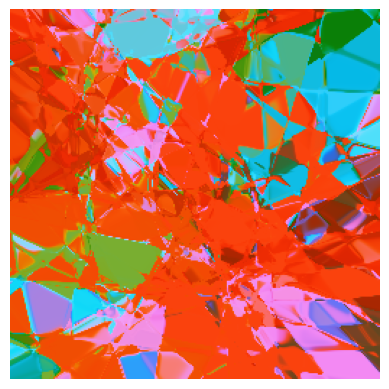

In [78]:
xres = 256
yres = 256
scale = 5
hidden_dims = [128, 128, 32, 32, 6, 6]
z_dim = 16
cppn = SimpleCPPN(input_dim=3, hidden_dims=hidden_dims, output_dim=3, z_dim=z_dim).cuda()

z = torch.randn(1, z_dim).cuda()
coords = create_coordinate_grid(scale, xres, yres)

target_image = Image.open('../targets/starry.jpg')

generated_img = generate_image(cppn, coords, xres, yres, z)

plt.imshow(generated_img)
plt.axis('off')
plt.show()

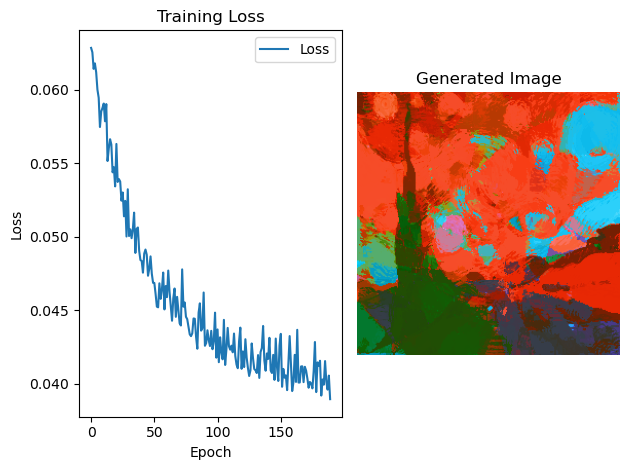

In [ ]:
train_cppn(cppn, coords, target_image, z, num_epochs=500, learning_rate=1e-3, trainable_layers='only_coords')

generated_img = generate_image(cppn, coords, xres, yres, z)

plt.imshow(generated_img)
plt.axis('off')
plt.show()

100%|██████████| 8/8 [00:00<00:00, 89.88it/s]


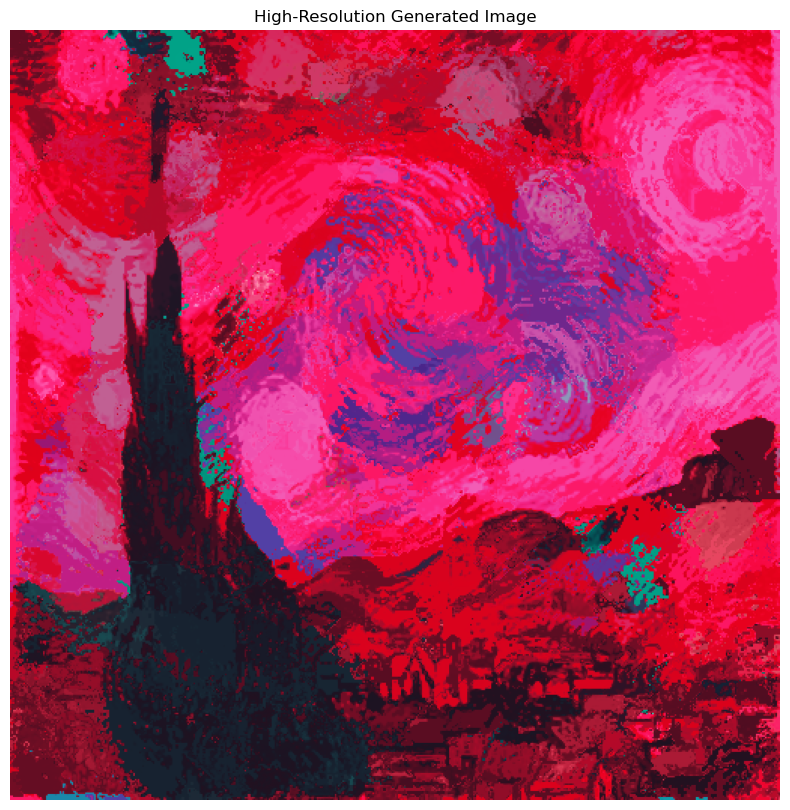

In [70]:
hires_img = generate_hires(cppn, z=z, trained_coords=coords, scale=scale, x_dim=64, y_dim=64, x_reps=8, y_reps=8)

plt.figure(figsize=(10, 10))
plt.imshow(hires_img)
plt.axis('off')
plt.title('High-Resolution Generated Image')
plt.show()

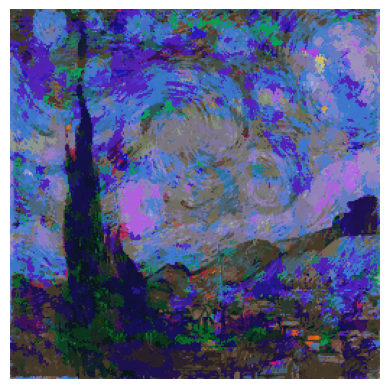

In [18]:
generated_img = generate_image(cppn, coords, xres, yres, z)

plt.imshow(generated_img)
plt.axis('off')
plt.show()

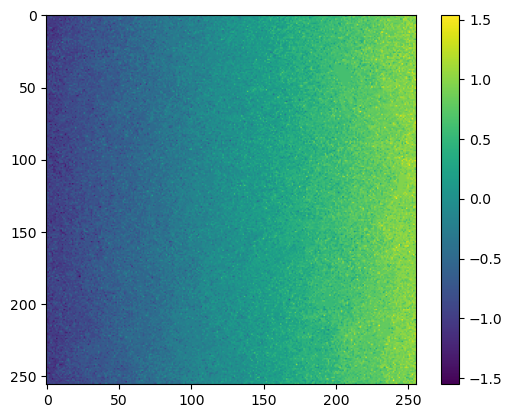

In [59]:
plt.imshow(coords.reshape(xres, yres, 3)[...,0].detach().cpu().numpy()); plt.colorbar()

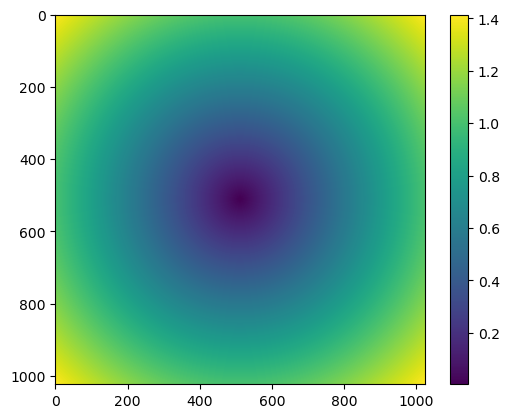

In [53]:
plt.imshow(linear_interpolate_coords(coords, (1024, 1024)).cpu().numpy()[..., 2]); plt.colorbar()